In [1]:
import sys
sys.path.append("..")  # Adjusts the path to include the parent directory

from rps_simulation.rps_base import RPS_Basic, RPS_Basic_Multirun  # Importing RPS_Basic class from rps_base.py
from rps_simulation.learning_curves import sigmoid_skill_update, exponential_skill_update, richards_skill_update 
from rps_simulation.forgetting_curves import exponential_forgetting 
from rps_simulation.practice_rate import simple_practice_rate 
from rps_simulation.waiting_times import exponential_waiting_time 


We imported different learning functions above

# 1. RPS_Basic Class:

This class generates one instance of the Basic RPS Model. The waiting time distributions, skill update function derived from the learning curve, forgetting rates and practice_rate equation have to be provided and can all be changed:


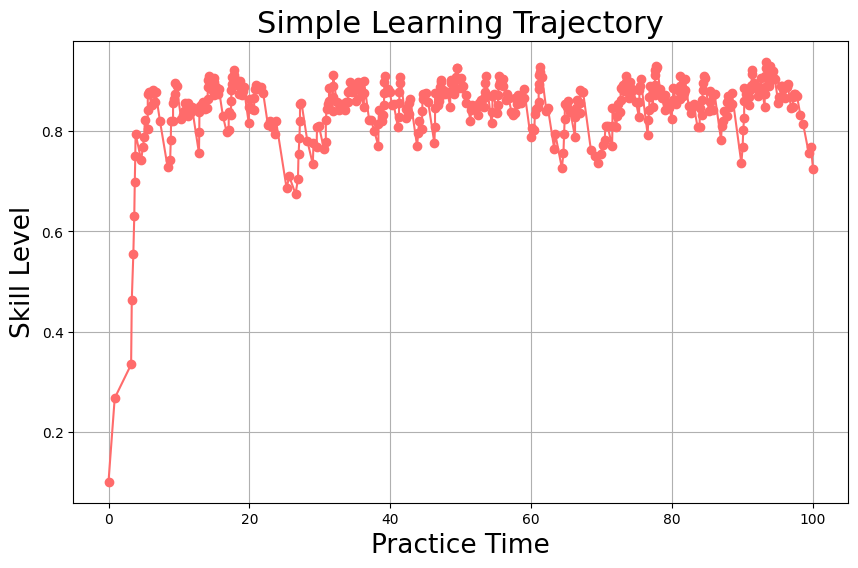

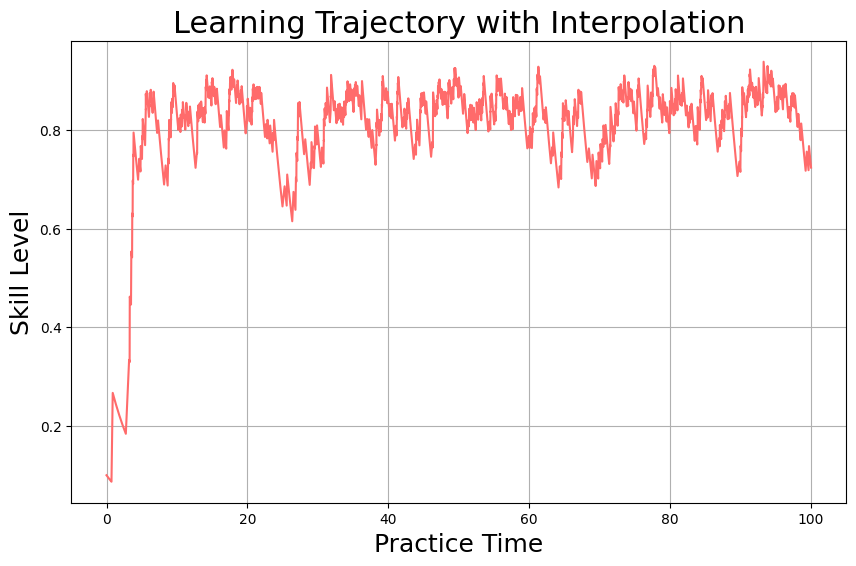

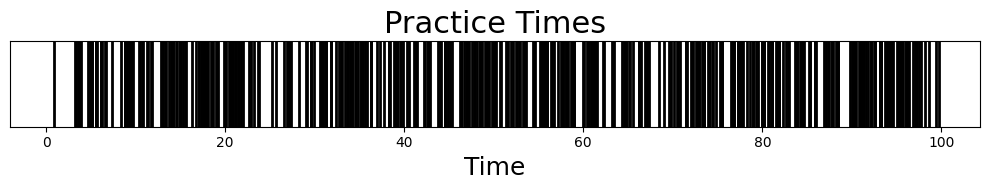

dict_keys(['final_skill', 'final_practice_rate', 'total_practice_events', 'time_lags', 'practice_times', 'skill_levels', 'practice_rates'])

In [2]:
# Instantiate a version of the RPS_Basic model with exponential waiting time, concave learning function,
# exponential forgetting and a simple practice function = a + bS
sample_concave = RPS_Basic(waiting_time_dist=exponential_waiting_time,
                 skill_update_func=exponential_skill_update,
                 forgetting_func=exponential_forgetting,
                 practice_rate_func=simple_practice_rate)

# run simulation:
sample_concave.run_simulation()

# simple learning trajectory with markers for practice events:
sample_concave.plot_simple_trajectory()

# plot trajectory
sample_concave.plot_learning_trajectory()

# Can also generate timestamp plots of when practice_events occured:
sample_concave.practice_times_plot()


# Get data form the simulation run and collect it in a dictionary
sample_data = sample_concave.data()
sample_data.keys()

# 2. RPS_Basic_Multirun
## 2.1 Concave Simulation and Plots



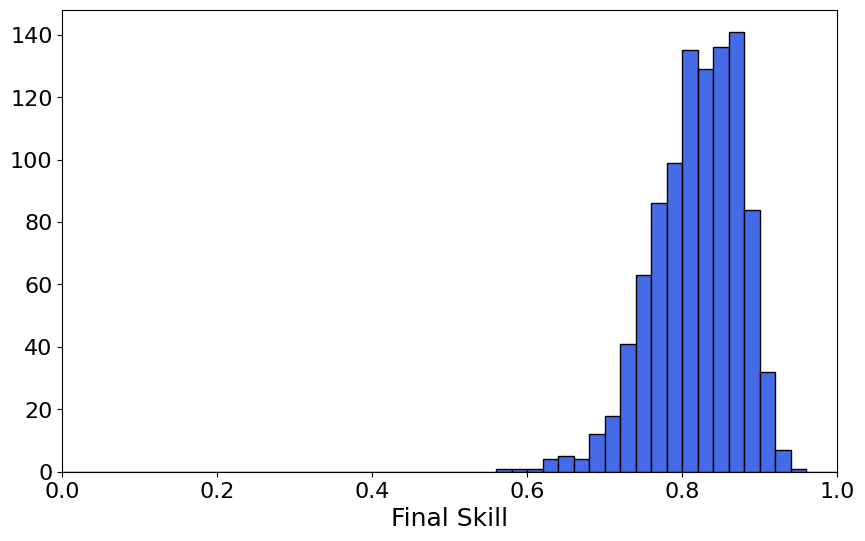

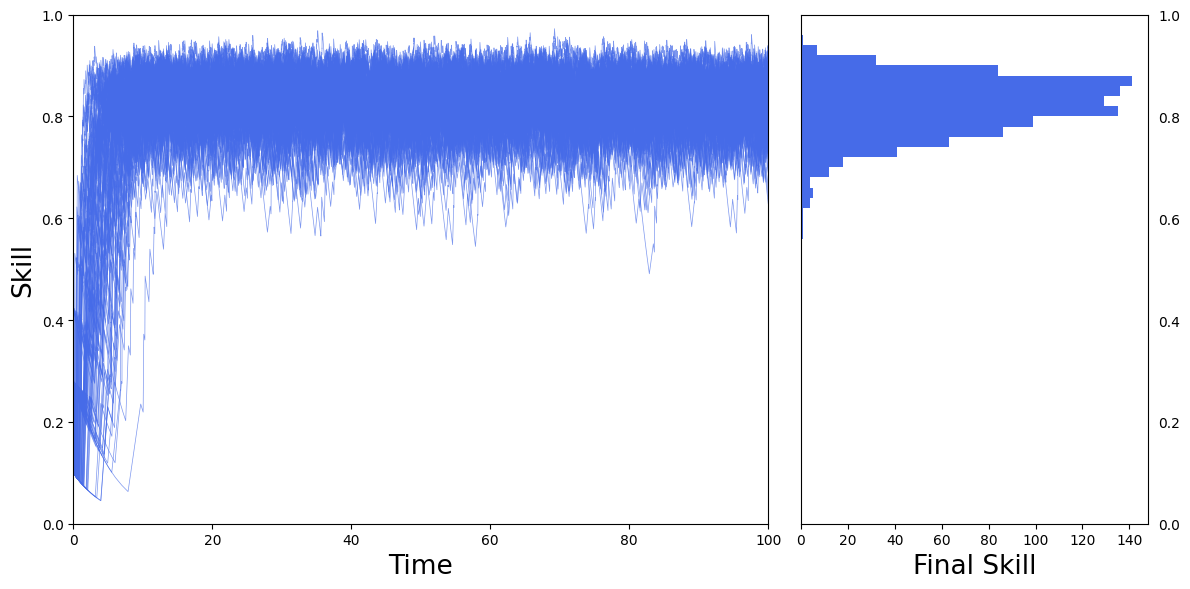

In [3]:
########## Concave Simulation and Plots ##########

# initializing the class
concave_sims = RPS_Basic_Multirun(waiting_time_dist=exponential_waiting_time,
                                skill_update_func=exponential_skill_update,
                                 forgetting_func=exponential_forgetting,
                                 practice_rate_func=simple_practice_rate,
                                 n_sims=1000)
# running the simulations
concave_sims.run_multiple_sims() 

concave_colour = '#466be8'
# plot final skill histogram:
concave_sims.plot_final_skill_histogram(colour=concave_colour)
 
# combined_plot
concave_sims.plot_trajectory_and_histogram(colour_lineplots=concave_colour, colour_histogram=concave_colour, n_plots=100, save_location='../plots/concave_sim_summary.png')



## 2.2 Sigmoid Simulation and Plots

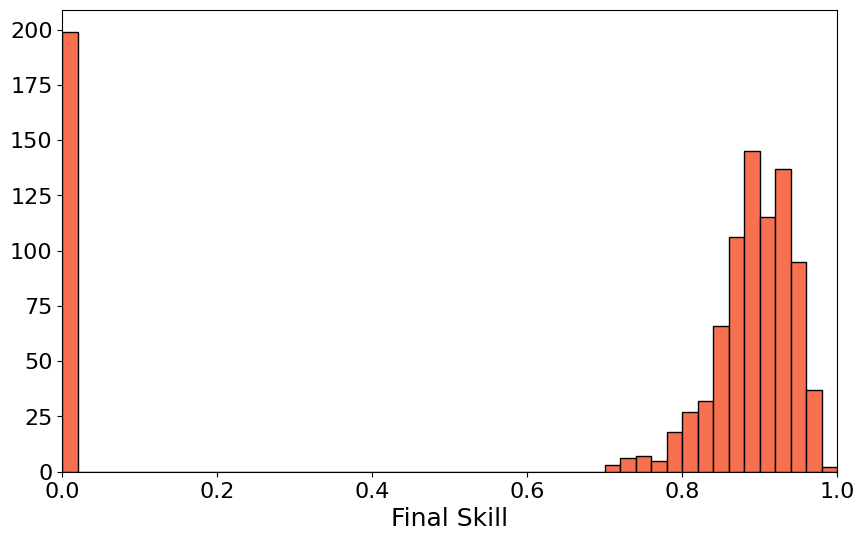

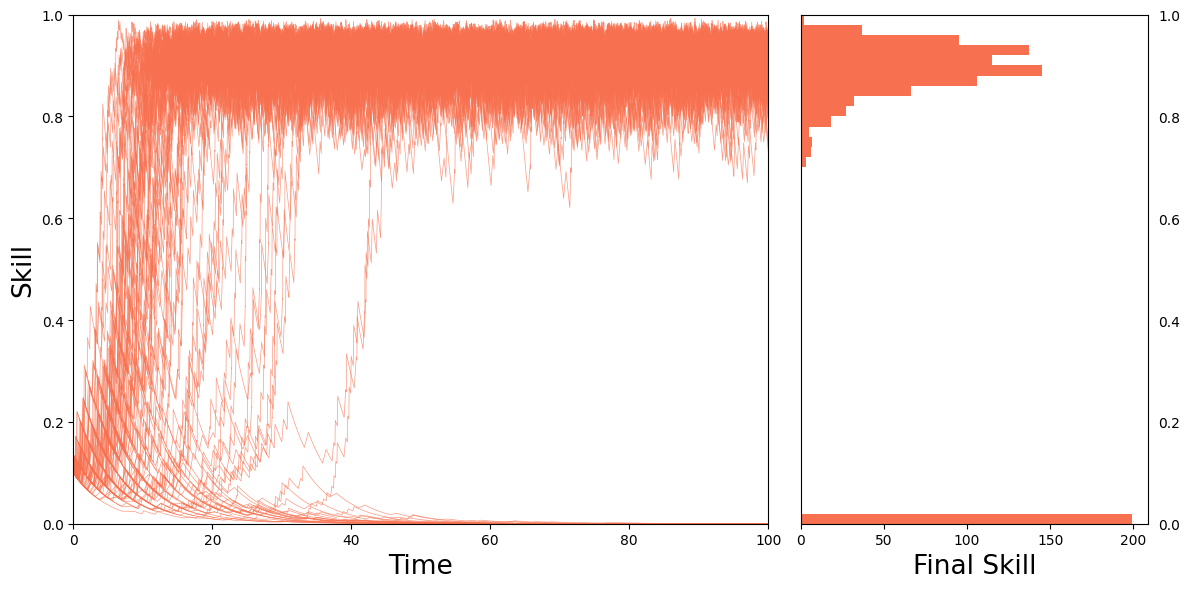

In [4]:
# initializing the class
sigmoid_sims = RPS_Basic_Multirun(waiting_time_dist=exponential_waiting_time,
                                skill_update_func=sigmoid_skill_update,
                                 forgetting_func=exponential_forgetting,
                                 practice_rate_func=simple_practice_rate,
                                 n_sims=1000)
# running the simulations
sigmoid_sims.run_multiple_sims() 

sigmoid_colour = '#f77150'
# plot final skill histogram:
sigmoid_sims.plot_final_skill_histogram(colour=sigmoid_colour)

# combined_plot
sigmoid_sims.plot_trajectory_and_histogram(colour_lineplots=sigmoid_colour, colour_histogram=sigmoid_colour, n_plots=100, save_location='../plots/sigmoid_sim_summary.png')
